# 1. Elija una de las imágenes color que tomó para la clase y aplique separación de canales y elija un método para transformarla en escala de grises. Muestre por pantalla los resultados obtenidos.

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import cv2

## Imagen original

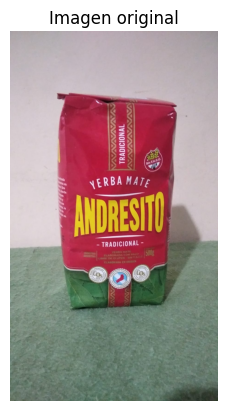

(<matplotlib.image.AxesImage at 0x7f97e4390490>,
 Text(0.5, 1.0, 'Imagen original'),
 None)

In [18]:
img1 = cv2.imread('img/img2.jpeg')
plt.axis('off')

img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1_rgb), plt.title('Imagen original'), plt.show()

## Separación de canales RGB

In [45]:
img1_R, img1_G, img1_B = cv2.split(img1_rgb)

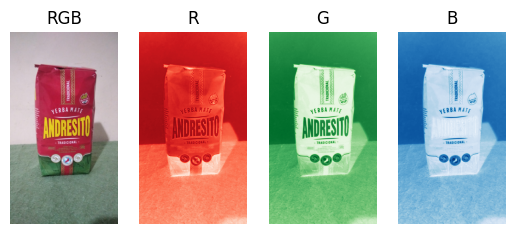

In [24]:
plt.subplot(141)
plt.axis('off')
plt.title('RGB')
plt.imshow(img1_rgb)

plt.subplot(142)
plt.axis('off')
plt.title('R')
plt.imshow(img1_R, cmap='Reds')

plt.subplot(143)
plt.axis('off')
plt.title('G')
plt.imshow(img1_G, cmap='Greens')

plt.subplot(144)
plt.axis('off')
plt.title('B')
plt.imshow(img1_B, cmap='Blues')

plt.show()

## Escala de grises

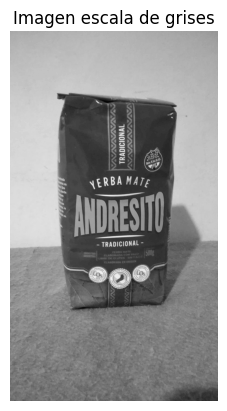

In [21]:
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
plt.imshow(img1_gray, cmap='gray')
plt.axis('off')
plt.title('Imagen escala de grises')
plt.show()

# 2. Con las fotografías pedidas por la cátedra la clase pasada (la foto de objetos con fondo liso, y fotos del mismo producto en un contexto más complejo) usar los métodos de extracción de características (esos anteriores al Deep Learning) para encontrar la ubicación del producto dentro de la imagen.